In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
import numpy as np
import os
from os.path import join
from statsmodels.tsa.tsatools import detrend
import statsmodels.formula.api as sm
import itertools
import sys
import datetime
# sns.set()
idx = pd.IndexSlice

In [2]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [3]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [4]:
%aimport Analysis.index
from Analysis.index import facility_co2, adjust_epa_emissions, group_fuel_cats
from Analysis.index import reduce_emission_factors, add_datetime
%aimport util.utils
from util.utils import rename_cols

## Load CO₂ intensity and percent gen data

### CO₂ intensity (aka *index*)

In [5]:
cwd = os.getcwd()
path = join(cwd, '..', 'Data storage', 'National data', 'National index.csv')
national_index = pd.read_csv(path, parse_dates=['datetime'])
national_index['nerc'] = 'USA'
rename_cols(national_index)

In [6]:
national_index.head()

,year,month,generation (mwh),final co2 (kg),datetime,quarter,index (g/kwh),change since 2005,index (lb/mwh),nerc
0,2001,1,332493160.0,2.149920e+11,2001-01-01,1,646.604591,0.076326,1425.504481,USA
1,2001,2,282940198.0,1.803140e+11,2001-02-01,1,637.284923,0.060812,1404.958340,USA
2,2001,3,300706544.0,1.891340e+11,2001-03-01,1,628.965732,0.046964,1386.617853,USA
3,2001,4,278078871.0,1.748850e+11,2001-04-01,2,628.902838,0.046860,1386.479197,USA
4,2001,5,300491621.0,1.892470e+11,2001-05-01,2,629.790069,0.048337,1388.435187,USA


In [11]:
path = join(cwd, '..', 'Data storage',
            'final NERC data', 'NERC gen emissions and index.csv')
nerc_index = pd.read_csv(path, parse_dates=['datetime'])
nerc_index.rename(columns={'index': 'index (g/kwh)'}, inplace=True)

In [12]:
nerc_index.head()

,year,nerc,month,final co2 (kg),generation (mwh),index (g/kwh),datetime
0,2001,-,1,5.476076e+09,7185661.388,762.083771,2001-01-01
1,2001,-,2,4.349473e+09,6526739.453,666.408193,2001-02-01
2,2001,-,3,4.223575e+09,6304139.884,669.968545,2001-03-01
3,2001,-,4,4.544873e+09,6624660.323,686.053817,2001-04-01
4,2001,-,5,4.972656e+09,7045482.729,705.793523,2001-05-01


### Percent generation

In [7]:
path = join(cwd, '..', 'Data storage',
            'National data', 'National percent gen.csv')
national_per_gen = pd.read_csv(path)
add_datetime(national_per_gen)
national_per_gen['nerc'] = 'USA'
national_per_gen.rename(columns={'generation (mwh)': 'Fraction Generation'},
                        inplace=True)

In [8]:
national_per_gen.head()

,year,month,fuel category,Fraction Generation,datetime,nerc
0,2001,1,Coal,0.533205,2001-01-01,USA
1,2001,2,Coal,0.529212,2001-02-01,USA
2,2001,3,Coal,0.516347,2001-03-01,USA
3,2001,4,Coal,0.505866,2001-04-01,USA
4,2001,5,Coal,0.504483,2001-05-01,USA


In [13]:
path = join(cwd, '..', 'Data storage',
            'final NERC data', 'NERC percent gen.csv')
nerc_per_gen = pd.read_csv(path, parse_dates=['datetime'])
nerc_per_gen.drop(['year', 'month'], inplace=True, axis=1)
nerc_per_gen.rename(columns={'generation (mwh)': 'Fraction Generation'}, inplace=True)

In [14]:
nerc_per_gen.head()

,fuel category,datetime,nerc,Fraction Generation
0,Coal,2001-01-01,-,0.693624
1,Coal,2001-02-01,-,0.616249
2,Coal,2001-03-01,-,0.601500
3,Coal,2001-04-01,-,0.621707
4,Coal,2001-05-01,-,0.637201


### Absolute generation

In [9]:
path = join(cwd, '..', 'Data storage',
            'National data', 'National generation.csv')
national_gen = pd.read_csv(path)
add_datetime(national_gen)
national_gen['nerc'] = 'USA'

In [10]:
national_gen.head()

,fuel category,year,month,generation (mwh),datetime,nerc
0,Coal,2001,1,177287111.0,2001-01-01,USA
1,Coal,2001,2,149735484.0,2001-02-01,USA
2,Coal,2001,3,155269011.0,2001-03-01,USA
3,Coal,2001,4,140670654.0,2001-04-01,USA
4,Coal,2001,5,151592914.0,2001-05-01,USA


In [15]:
index_cols = ['nerc', 'generation (mwh)', 'datetime']
nerc_gen = pd.merge(nerc_per_gen, nerc_index[index_cols],
                    on=['nerc', 'datetime'])
nerc_gen.rename(columns={'generation (mwh)' : 'total generation (mwh)'},
                inplace=True)
nerc_gen['generation (mwh)'] = (nerc_gen['Fraction Generation']
                                * nerc_gen['total generation (mwh)'])
nerc_gen.set_index(['nerc', 'fuel category', 'datetime'], inplace=True)
nerc_gen.head()

Fraction Generation  total generation (mwh)  \
nerc fuel category datetime                                                  
-    Coal          2001-01-01             0.693624             7185661.388   
     Hydro         2001-01-01             0.038756             7185661.388   
     Natural Gas   2001-01-01             0.034199             7185661.388   
     Nuclear       2001-01-01             0.222582             7185661.388   
     Other         2001-01-01             0.010840             7185661.388   

                               generation (mwh)  
nerc fuel category datetime                      
-    Coal          2001-01-01       4984145.332  
     Hydro         2001-01-01        278484.523  
     Natural Gas   2001-01-01        245740.990  
     Nuclear       2001-01-01       1599398.000  
     Other         2001-01-01         77892.543

#### Add generation by different fuel sources to get total generation by NERC

In [16]:
total = nerc_gen.groupby(['nerc', 'datetime'])['Fraction Generation',
                                               'generation (mwh)'].sum()
total['fuel category'] = 'Total'
total.set_index('fuel category', append=True, inplace=True)
total = total.reorder_levels(['nerc', 'fuel category', 'datetime'])
total.head()

Fraction Generation  generation (mwh)
nerc fuel category datetime                                         
-    Total         2001-01-01                  1.0       7185661.388
                   2001-02-01                  1.0       6526739.453
                   2001-03-01                  1.0       6304139.884
                   2001-04-01                  1.0       6624660.323
                   2001-05-01                  1.0       7045482.729

In [17]:
nerc_gen = pd.concat([nerc_gen, total])
nerc_gen.sort_index(inplace=True)

## Combine NERC and national results

### CO₂ intensity

In [19]:
index = pd.concat([national_index, nerc_index])

In [20]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.076326,2001-01-01,2.149920e+11,332493160.0,646.604591,1425.504481,1,USA,1.0,2001
1,0.060812,2001-02-01,1.803140e+11,282940198.0,637.284923,1404.958340,2,USA,1.0,2001
2,0.046964,2001-03-01,1.891340e+11,300706544.0,628.965732,1386.617853,3,USA,1.0,2001
3,0.046860,2001-04-01,1.748850e+11,278078871.0,628.902838,1386.479197,4,USA,2.0,2001
4,0.048337,2001-05-01,1.892470e+11,300491621.0,629.790069,1388.435187,5,USA,2.0,2001


### Percent generation

In [21]:
per_gen = pd.concat([national_per_gen, nerc_per_gen])

per_gen.year = per_gen['datetime'].dt.year
per_gen.month = per_gen['datetime'].dt.month

In [22]:
per_gen.head()

,Fraction Generation,datetime,fuel category,month,nerc,year
0,0.533205,2001-01-01,Coal,1,USA,2001
1,0.529212,2001-02-01,Coal,2,USA,2001
2,0.516347,2001-03-01,Coal,3,USA,2001
3,0.505866,2001-04-01,Coal,4,USA,2001
4,0.504483,2001-05-01,Coal,5,USA,2001


### Total generation

In [23]:
national_gen.head()

,fuel category,year,month,generation (mwh),datetime,nerc
0,Coal,2001,1,177287111.0,2001-01-01,USA
1,Coal,2001,2,149735484.0,2001-02-01,USA
2,Coal,2001,3,155269011.0,2001-03-01,USA
3,Coal,2001,4,140670654.0,2001-04-01,USA
4,Coal,2001,5,151592914.0,2001-05-01,USA


In [24]:
cols = ['nerc', 'fuel category', 'datetime']
gen = pd.concat([national_gen.set_index(cols), nerc_gen])
gen.sort_index(inplace=True)
gen.drop(['Fraction Generation', 'total generation (mwh)'], axis=1,
         inplace=True)

In [25]:
gen.head()

generation (mwh)  month  year
nerc fuel category datetime                                 
-    Coal          2001-01-01       4984145.332    NaN   NaN
                   2001-02-01       4022096.265    NaN   NaN
                   2001-03-01       3791937.999    NaN   NaN
                   2001-04-01       4118597.061    NaN   NaN
                   2001-05-01       4489386.854    NaN   NaN

## Figures

In [51]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})
sns.set_context('notebook', font_scale=1.2)

In [27]:
def region_facet_grid(df, plot_function, x_axis, y_axis, col_order=None,
                      suptitle='', add_legend=False, x_label=None, 
                      y_label=None, FG_kwargs={}, plot_kwargs={},
                      context='notebook', font_scale=1.2):
    sns.set_context(context, font_scale)
    g = sns.FacetGrid(df, col_order=col_order, **FG_kwargs)
    g.map(plot_function, x_axis, y_axis, **plot_kwargs)
    g.set_xticklabels(rotation=35)
    if add_legend:
        g.add_legend()
    if suptitle:
        plt.suptitle(suptitle, y=1.02, size=15)
    if col_order and 'col' in FG_kwargs:
        axes = g.axes.flatten()
        for ax, title in zip(axes, order):
            ax.set_title(title)
    if x_label or y_label:
        g.set_axis_labels(x_label, y_label)

### Index figure

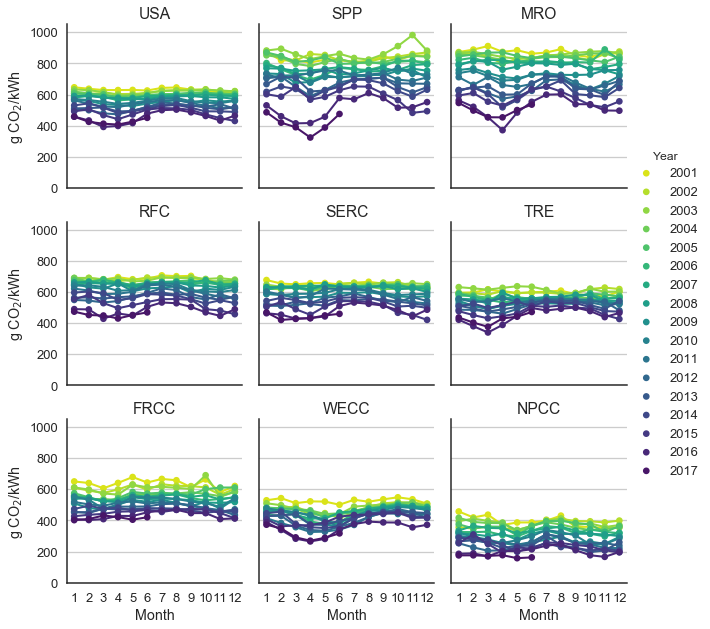

In [29]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = index.copy()
temp.rename(columns={'month': 'Month',
                     'year': 'Year'}, inplace=True)
with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='index (g/kwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('g CO$_2$/kWh')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')
plt.savefig(path, bbox_inches='tight')

#### Alternate plot of CO₂ intensity

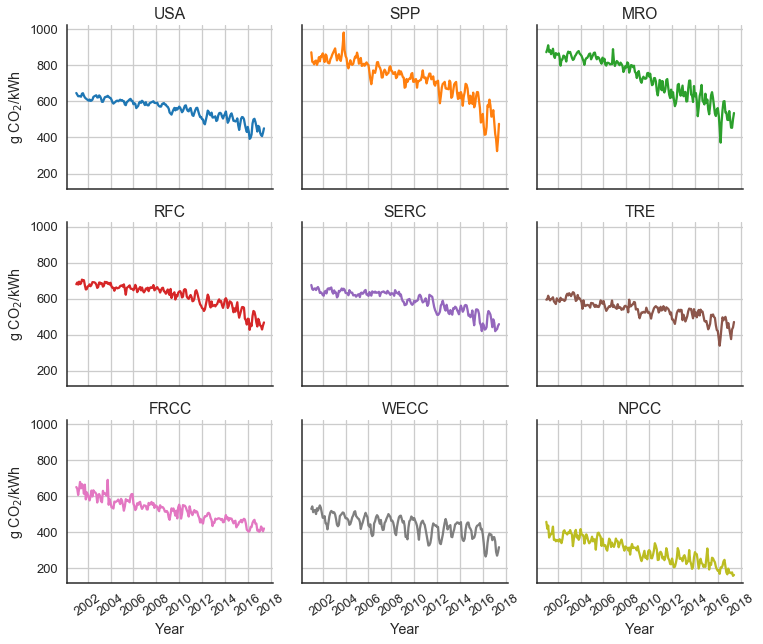

In [30]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

region_facet_grid(df=index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='talk', font_scale=1)
path = join(cwd, '..', 'Figures', 'SI', 'Monthly index by region.pdf')
plt.savefig(path, bbox_inches='tight')

#### Plot of detrended intensity, using a linear detrend
Not a good method - trend isn't linear

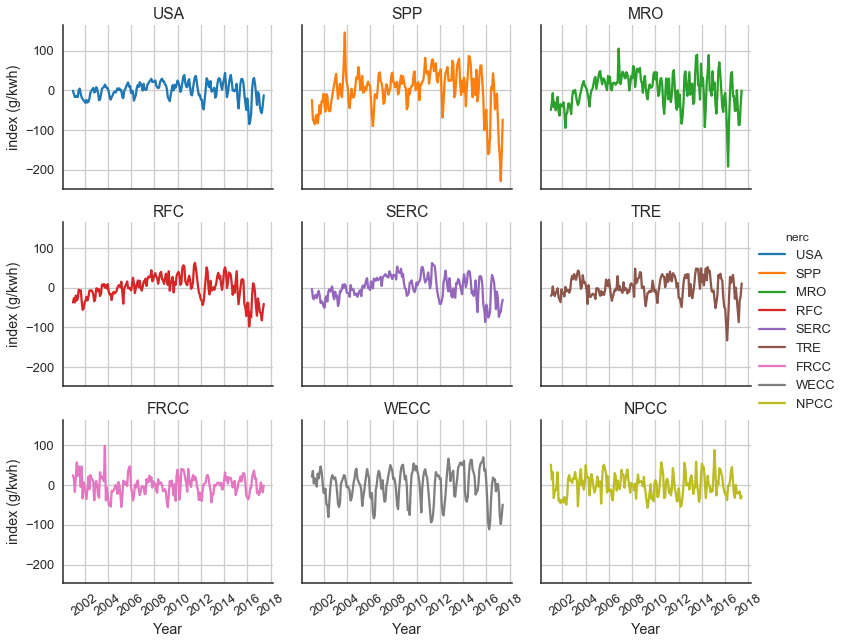

In [31]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Plot of detrended intensity using a first difference detrend
Better than linear, but I'm not sure it's appropriate

In [32]:
def diff_detrend(series, n=1):
    d = series - series.shift(n)
    return d

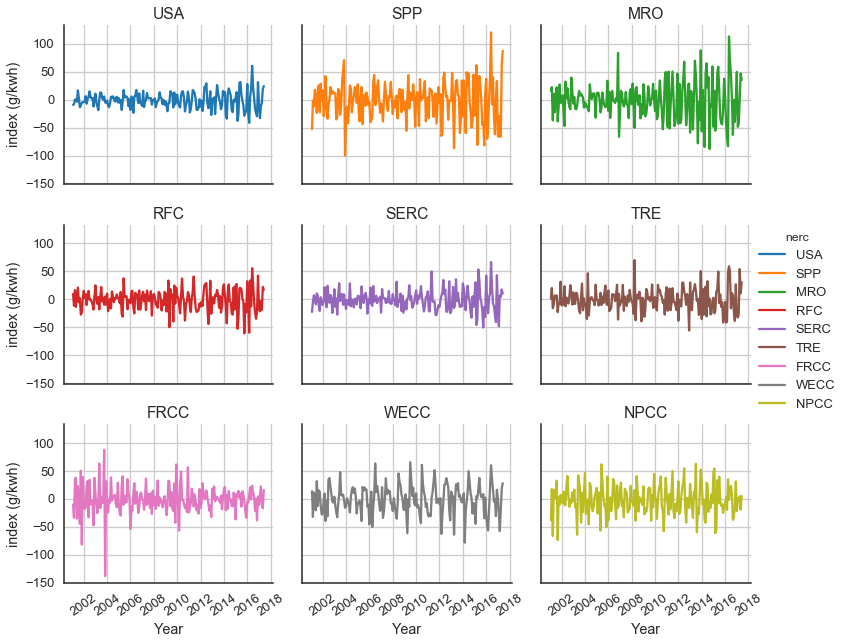

In [33]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = diff_detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

Using a difference from same month in the previous year rather than previous month.

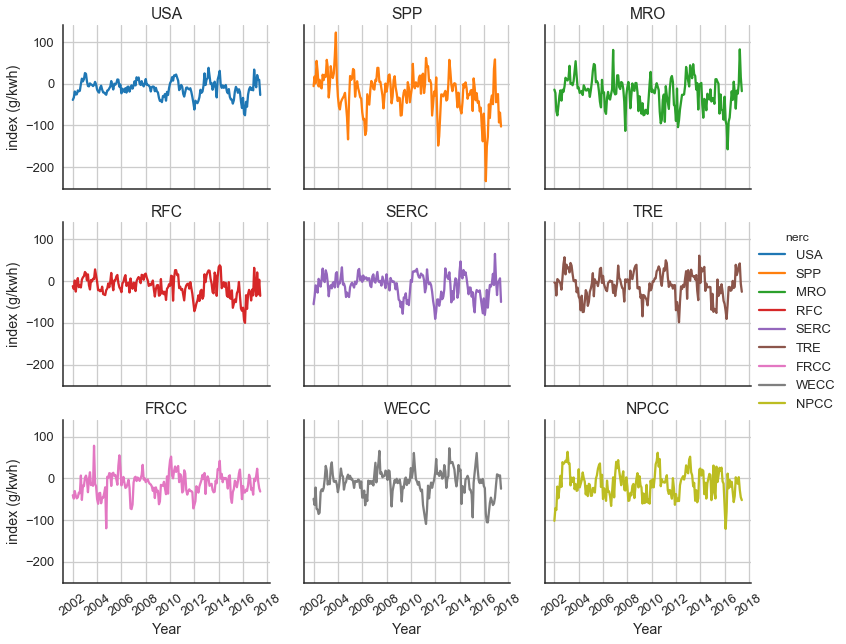

In [34]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = diff_detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'], 12)


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Detrend by subtracting the rolling 1-year mean

Started by using `seasonal_decompose` from statsmodels. It was apparent that the `trend` component is just the rolling average. I'm leaving the extra code here as documentation of this fact.

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [30]:
wecc = index.loc[index['nerc'] == 'WECC', ['index (g/kwh)', 'datetime']]
wecc.set_index('datetime', inplace=True)
wecc.head()

,index (g/kwh)
datetime,
2001-01-01,529.192626
2001-02-01,542.909017
2001-03-01,510.778747
2001-04-01,522.251450
2001-05-01,521.037692


In [31]:
sd = seasonal_decompose(wecc)

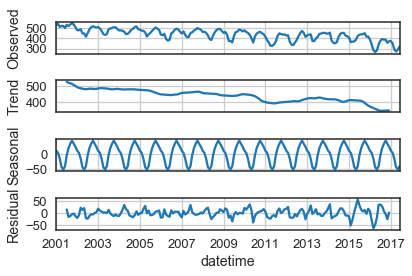

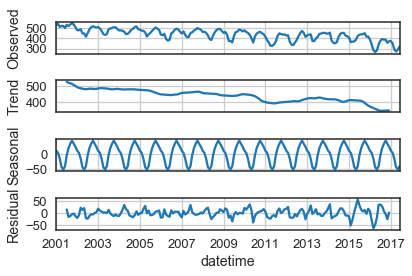

In [391]:
sd.plot()

These three things are all the same:
1. Subtracting just the *trend* from the `WECC` data
2. Adding the *seasonal* and *resid* components
3. Subtracting the annual rolling mean from the `WECC` data

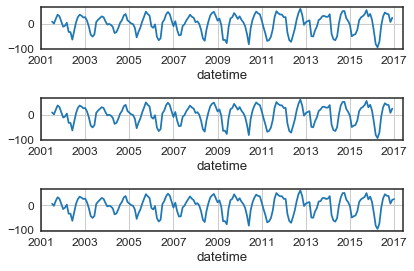

In [43]:
fig, ax = plt.subplots(nrows=3, squeeze=True)
(wecc - sd.trend).plot(ax=ax[0], legend=False)
(sd.seasonal + sd.resid).plot(ax=ax[1], legend=False)
(wecc - wecc.rolling(12, center=True).mean()).plot(ax=ax[2], legend=False)
plt.tight_layout()

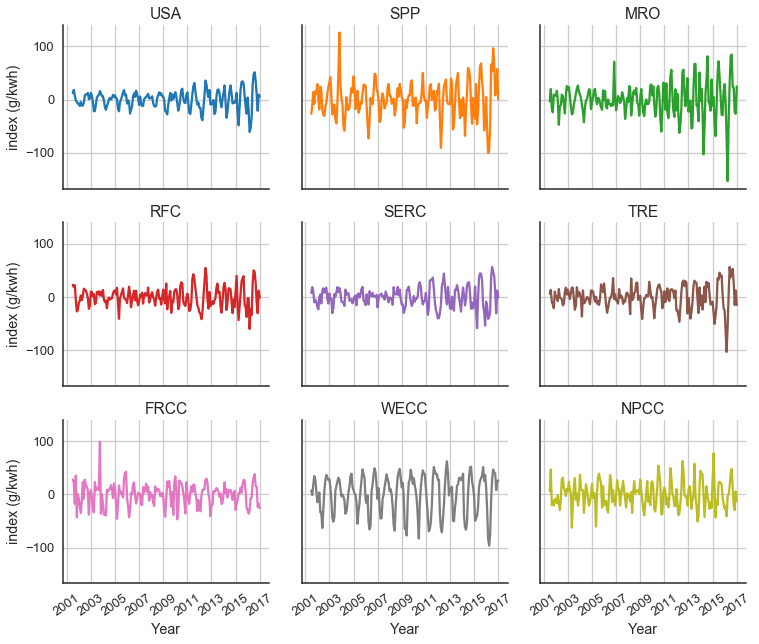

In [38]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

temp = index.copy()
temp.set_index('datetime', inplace=True)

df_list = []
for nerc in order:
    # Subtract the rolling mean from the raw data in each region
    sd = (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
          - (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
             .rolling(12, center=True)
             .mean()))
    # Have to make the series into a df to add the 'nerc' column
    sd = pd.DataFrame(sd)
    sd['nerc'] = nerc
    df_list.append(sd)
    
detrend_index = pd.concat(df_list)

region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Create a combined figure for the SI
Include the raw monthly data, the rolling mean trend line, and the detrended data

In [46]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.076326,2001-01-01,2.149920e+11,332493160.0,646.604591,1425.504481,1,USA,1.0,2001
1,0.060812,2001-02-01,1.803140e+11,282940198.0,637.284923,1404.958340,2,USA,1.0,2001
2,0.046964,2001-03-01,1.891340e+11,300706544.0,628.965732,1386.617853,3,USA,1.0,2001
3,0.046860,2001-04-01,1.748850e+11,278078871.0,628.902838,1386.479197,4,USA,2.0,2001
4,0.048337,2001-05-01,1.892470e+11,300491621.0,629.790069,1388.435187,5,USA,2.0,2001


In [47]:
detrend_index.head()

,index (g/kwh),nerc
datetime,,
2001-01-01,NaN,USA
2001-02-01,NaN,USA
2001-03-01,NaN,USA
2001-04-01,NaN,USA
2001-05-01,NaN,USA


In [49]:
combined = index.copy()
combined.set_index(['nerc', 'datetime'], inplace=True)
df = detrend_index.reset_index(drop=False).set_index(['nerc', 'datetime'])
df.columns = ['detrend index']

In [50]:
combined = pd.concat([index.set_index(['nerc', 'datetime']), df])

In [51]:
combined.head()

change since 2005  detrend index  final co2 (kg)  \
nerc datetime                                                       
USA  2001-01-01           0.076326            NaN    2.149920e+11   
     2001-02-01           0.060812            NaN    1.803140e+11   
     2001-03-01           0.046964            NaN    1.891340e+11   
     2001-04-01           0.046860            NaN    1.748850e+11   
     2001-05-01           0.048337            NaN    1.892470e+11   

                 generation (mwh)  index (g/kwh)  index (lb/mwh)  month  \
nerc datetime                                                             
USA  2001-01-01       332493160.0     646.604591     1425.504481    1.0   
     2001-02-01       282940198.0     637.284923     1404.958340    2.0   
     2001-03-01       300706544.0     628.965732     1386.617853    3.0   
     2001-04-01       278078871.0     628.902838     1386.479197    4.0   
     2001-05-01       300491621.0     629.790069     1388.435187    5.0   

                 quarter    year  
nerc datetime                     
USA  2001-01-01      1.0  2001.0  
     2001-02-01      1.0  2001.0  
     2001-03-01      1.0  2001.0  
     2001-04-01      2.0  2001.0  
     2001-05-01      2.0  2001.0

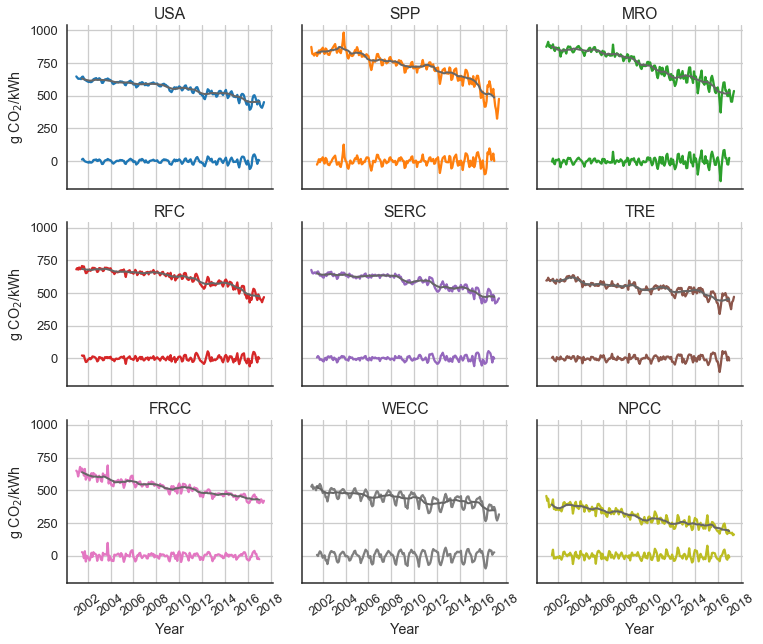

In [55]:
def plot_trend(x, y, **kws):
    'Plot function for the FacetGrid to plot all three data series'
    trend = y.rolling(12, center=True).mean()
    plt.plot(x, y, **kws)
    plt.plot(x, trend, lw=2, c='0.4')
    detrended = y - trend
    plt.plot(x, detrended, **kws)

order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

region_facet_grid(df=index.reset_index(), plot_function=plot_trend, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='talk', font_scale=1)
path = join(cwd, '..', 'Figures', 'SI',
            'Monthly index trend and detrended by region.pdf')
plt.savefig(path, bbox_inches='tight')

### Percent gen figures

#### Color palette for fuel categories

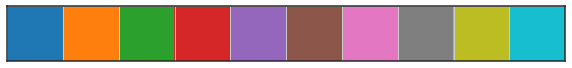

In [21]:
sns.palplot(sns.color_palette('tab10', n_colors=10))

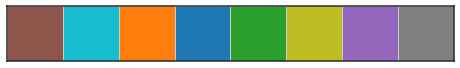

In [32]:
fuel_order = [5, -1, 1, 0, 2, -2, 4, -3]
fuel_palette = [sns.color_palette('tab10', n_colors=10)[x]
                for x in fuel_order]
sns.palplot(fuel_palette)

In [101]:
gen.head()

generation (mwh)  month    year
nerc fuel category datetime                                   
USA  Coal          2001-01-01       177287111.0    1.0  2001.0
                   2001-02-01       149735484.0    2.0  2001.0
                   2001-03-01       155269011.0    3.0  2001.0
                   2001-04-01       140670654.0    4.0  2001.0
                   2001-05-01       151592914.0    5.0  2001.0

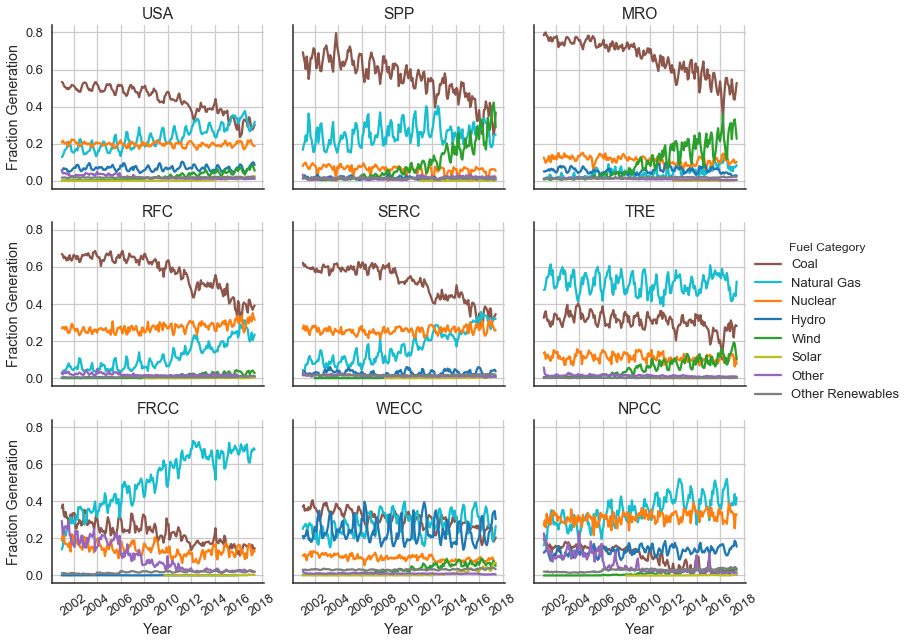

In [57]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
              'Other', 'Other Renewables']
temp = per_gen.copy()
temp.rename(columns={'fuel category': 'Fuel Category'}, inplace=True)

FG_kwargs = dict(hue='Fuel Category',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order,
                 palette=fuel_palette)

region_facet_grid(df=temp, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='Fraction Generation', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

path = join(cwd, '..', 'Figures', 'Generation by fuel_full.pdf')
plt.savefig(path, bbox_inches='tight')

## Figure of wind, nat gas, and coal
Show how generation from these three resources has changed over time in SPP, TRE, and MRO.

In [82]:
per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].head()

,datetime,fuel category,Fraction Generation,month,nerc,year
2612,2005-01-01,Coal,0.753739,NaN,MRO,2005
2613,2005-02-01,Coal,0.766800,NaN,MRO,2005
2614,2005-03-01,Coal,0.780396,NaN,MRO,2005
2615,2005-04-01,Coal,0.774250,NaN,MRO,2005
2616,2005-05-01,Coal,0.762964,NaN,MRO,2005


In [28]:
order = ['SPP', 'TRE', 'MRO']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
per_gen.year = per_gen.year.astype(int)
temp_df = per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].copy()

def early_late(x):
    'Add classifications to each month based on the year'
    if x <= 2008:
        return '2005-2008'
    elif x <= 2012:
        return '2009-2012'
    elif x <= 2016:
        return '2013-2016'
    else:
        return ValueError

temp_df.loc[:, 'timeframe'] = temp_df.loc[:, 'year'].map(early_late)
merge_cols = ['nerc', 'month', 'year']
temp_df = pd.merge(temp_df, index[merge_cols + ['generation (mwh)']],
                   on=merge_cols)
temp_df['generation'] = (temp_df.loc[:, 'Fraction Generation']
                         * temp_df.loc[:, 'generation (mwh)'] / 1e6)

In [29]:
temp_df.head()

,Fraction Generation,datetime,fuel category,month,nerc,year,timeframe,generation (mwh),generation
0,0.753739,2005-01-01,Coal,1,MRO,2005,2005-2008,1.552018e+07,11.698157
1,0.025970,2005-01-01,Natural Gas,1,MRO,2005,2005-2008,1.552018e+07,0.403064
2,0.014663,2005-01-01,Wind,1,MRO,2005,2005-2008,1.552018e+07,0.227579
3,0.766800,2005-02-01,Coal,2,MRO,2005,2005-2008,1.338076e+07,10.260365
4,0.024931,2005-02-01,Natural Gas,2,MRO,2005,2005-2008,1.338076e+07,0.333600


In [33]:
# a is the list of colors
# Matching fuel colors to the generation plot above
a = fuel_palette[0:2]
a.append(fuel_palette[4])

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


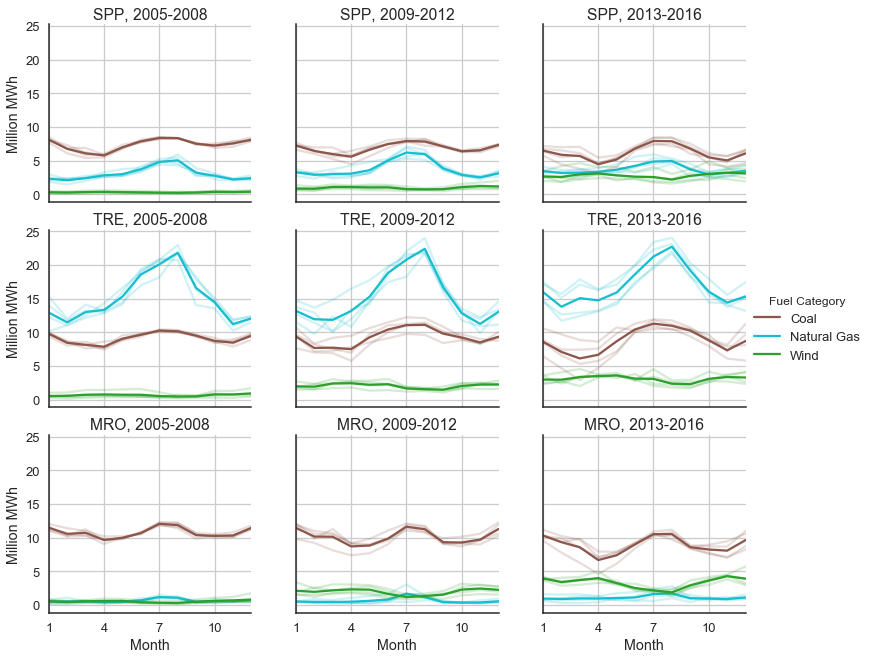

In [328]:
order = ['SPP', 'TRE', 'MRO']
col_order = ['2005-2008', '2009-2012', '2013-2016']

with sns.plotting_context(font_scale=1.2):
    g = sns.FacetGrid(temp_df, col='timeframe', row='nerc',
                      col_order=col_order, row_order=order, aspect=1.15)
    g.map_dataframe(sns.tsplot, time='month', unit='year', value='generation', 
                    condition='fuel category', err_style='unit_traces',
                    color=a).add_legend(title='Fuel Category')
    g.set_axis_labels('Month', 'Million MWh')
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, col_order))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.set_xticks([1, 4, 7, 10])

path = join(cwd, '..', 'Figures', 'Wind-Coal-NG variability tsplot.pdf')
plt.savefig(path, bbox_inches='tight')

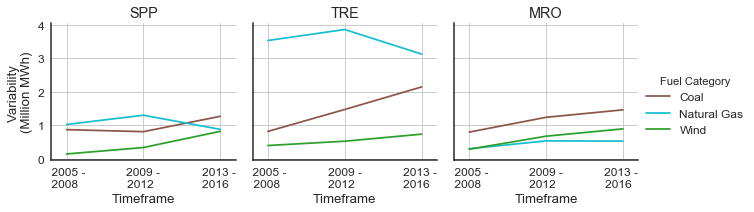

In [35]:
# Map quantitative values to the timeframes to make plotting easier
map_timeframe = {'2005-2008': 0,
                 '2009-2012': 0.5,
                 '2013-2016': 1}

data = (temp_df.groupby(['nerc', 'fuel category', 'timeframe'])
               .std()
               .reset_index())
data['frame'] = data['timeframe'].map(map_timeframe)
data.sort_values(['nerc', 'fuel category', 'frame'], inplace=True)

g = sns.FacetGrid(data, hue='fuel category', col='nerc',
                  col_order=['SPP', 'TRE', 'MRO'], palette=a)
g.map(plt.plot, 'frame', 'generation').add_legend(title='Fuel Category')
g.set_axis_labels('Timeframe', 'Variability\n(Million MWh)')
axes = g.axes.flatten()
for ax, nerc in zip(axes, ['SPP', 'TRE', 'MRO']):
    ax.set_title(nerc)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([' 2005 -\n 2008  ', '2009 -\n2012  ',
                        '2013 - \n2016   '])
    ax.set_xlim(-.1, 1.1)


path = join(cwd, '..', 'Figures', 'SI', 'Wind-Coal-NG variability.pdf')
plt.savefig(path, bbox_inches='tight')

## Correlation figures
Creating a wide dataframe and then melting it to a tidy one is extra work. Might want to come back and create a tidy df from the start.

In [47]:
# Pairs of adjacent NERC regions
region_pairs = [
#     ('WECC', 'MRO'),
    ('WECC', 'SPP'),
    ('WECC', 'TRE'),
    ('TRE', 'SPP'),
    ('TRE', 'SERC'),
    ('SPP', 'MRO'),
    ('SPP', 'SERC'),
    ('SERC', 'FRCC'),
    ('SERC', 'MRO'),
    ('RFC', 'SERC'),
    ('RFC', 'NPCC'),
    ('RFC', 'MRO'),
    ('MRO', 'NPCC'),
    ('MRO', 'WECC')
]

In [48]:
index.reset_index(inplace=True)
index.set_index(['nerc', 'datetime'], inplace=True)
index.sort_index(inplace=True)

In [49]:
index.head()

index  change since 2005  final co2 (kg)  generation (mwh)  \
nerc datetime                                                                 
-    2001-01-01      0                NaN    5.476076e+09       7185661.388   
     2001-02-01      1                NaN    4.349473e+09       6526739.453   
     2001-03-01      2                NaN    4.223575e+09       6304139.884   
     2001-04-01      3                NaN    4.544873e+09       6624660.323   
     2001-05-01      4                NaN    4.972656e+09       7045482.729   

                 index (g/kwh)  index (lb/mwh)  month  quarter  year  
nerc datetime                                                         
-    2001-01-01     762.083771             NaN      1      NaN  2001  
     2001-02-01     666.408193             NaN      2      NaN  2001  
     2001-03-01     669.968545             NaN      3      NaN  2001  
     2001-04-01     686.053817             NaN      4      NaN  2001  
     2001-05-01     705.793523             NaN      5      NaN  2001

In [44]:
def add_count(df):
    'Add a 0-indexed column for the regression line'
    nercs = df['variable'].unique()
    for nerc in nercs:
        df.loc[df['variable'] == nerc, 'count'] = range(len(df.loc[df['variable'] == nerc]))

In [61]:
def rolling_corr_plot(index, region_pairs, window, center=True,
                      order=None, legend_order=None, sup_title=None,
                      detrend_series=False, diff=False, annual=False, 
                      seasonal=False, shift=1):
    """
    Calculate the rolling correlation of detrended CO2 intensity between pairs
    of regions. Multiple detrend methods are possible, but only the "seasonal"
    method is used in the final figures.
    
    inputs:
        index (df): dataframe with monthly co2 intensity of each region
        region_pairs (dict): list of tuples, where each tuple is a pair of
            regions to compare
        window (int): length of the rolling window
        center (bool): if the rolling correlation window should be centered
        order (list): order of NERC region facet windows
        legend order (list): order of NERC regions in legend
        sup_title (str): sup title to place above the facet grid
        detrend_series (bool): if the co2 intensity data should be detrended
        diff (bool): use a differencing method to detrend
        annual (bool): use a linear regression detrend separately on each year
        seasonal (bool): detrend with a 12-month rolling mean
        shift (int): value of shift for the diff detrend method (1 = 1 month)
    """
    
    df = index.copy()
    
    df.reset_index(inplace=True)
    nercs = df['nerc'].unique()
    df.set_index(['nerc', 'datetime'], inplace=True)
    df.sort_index(inplace=True)
    
    df_list = []
    if detrend_series:
        for nerc in nercs:
            if diff:
                df.loc[idx[nerc, :], 'index (g/kwh)'] = \
                    diff_detrend(df.loc[idx[nerc, :], 'index (g/kwh)'], shift)
            
            if annual:
                df.loc[idx[nerc, :], 'index (g/kwh)'] = \
                    annual_detrend(df.loc[idx[nerc, :]])

            if seasonal:
                trend = (df.loc[nerc, 'index (g/kwh)']
                           .rolling(12, center=True)
                           .mean())
                detr = df.loc[nerc, 'index (g/kwh)'] - trend
                detr = pd.DataFrame(detr)
                detr['nerc'] = nerc
                df_list.append(detr)

            else:
                df.loc[idx[nerc, :], 'index (g/kwh)'] = \
                    detrend(df.loc[idx[nerc, :], 'index (g/kwh)'])
        
        if seasonal:
            # Need to concat the list of dataframes
            df = pd.concat(df_list)
            df.reset_index(inplace=True)
            df.set_index(['nerc', 'datetime'], inplace=True)
    
    df.dropna(inplace=True)

    corr_df = pd.concat([(df.loc[regions[0]]['index (g/kwh)']
                            .rolling(window, center=center)
                            .corr(df.loc[regions[1]]['index (g/kwh)']))
                         for regions in region_pairs], axis=1)
    
    # Create columns with the names of each region. Legacy code, but still
    # functional
    cols = ['{} | {}'.format(regions[0], regions[1]) 
            for regions in region_pairs]
    corr_df.columns = cols
    
    # Go from wide-format to tidy
    corr_tidy = pd.melt(corr_df.reset_index(), id_vars=['datetime'],
                        value_name='Correlation')
    corr_tidy['region1'] = corr_tidy['variable'].str.split(' | ').str[0]
    corr_tidy['region2'] = corr_tidy['variable'].str.split(' | ').str[-1]
    
    # Add the 0-indexed 'count' column
    add_count(corr_tidy)
    
    if not order:
        order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
        
    if not legend_order:
        legend_order = ['SPP', 'TRE', 'SERC', 'MRO', 'FRCC', 'NPCC', 'WECC']
    legend_len = len(legend_order)
    
    g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.2,
                      hue='region2', palette='tab10', size=2.5,
                      hue_order=legend_order)
    # Use regplot to get the regression line, but set scatter marker size to 0
    g.map(sns.regplot, 'count', 'Correlation', marker='.',
          truncate=True, scatter_kws={'s': 0})

    # regplot only does a scatter - add plt.plot for the lines
    g.map(plt.plot, 'count', 'Correlation')


    # Create custom patch lines for the legend - the default dots were small
    plot_colors = sns.color_palette('tab10', legend_len)
    legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
    legend_data = dict(zip(legend_order, legend_patches))
    g.add_legend(legend_data=legend_data, title='Second Region')

    axes = g.axes.flatten()

    # Grid lines at the start of each even year from 2004-16
    years = range(2004, 2017, 2)
    distance = 24 # months in 2 years
    # tick locations
    x_ticks = [(x * distance) + 6 for x in range(1, 8)]
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_xticks(x_ticks)

    # Year for the ticklabels
    g.set_xticklabels(years, rotation=35)
    g.set_xlabels('Year')
    
    # Suptitle if desired
    if sup_title:
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(sup_title)

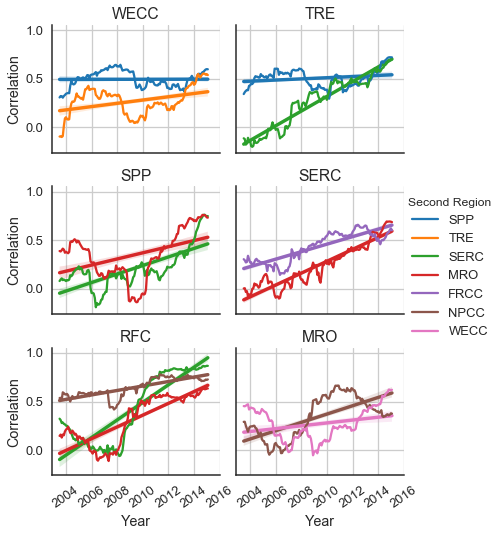

In [72]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48, x_lim=(2002, 2016),
                       detrend_series=True, seasonal=True)
path = join(cwd, '..', 'Figures', 'Rolling correlation - seasonal detrend 48m centered.pdf')
# plt.savefig(path, bbox_inches='tight')

#### Additional rolling windows for comparison and the SI

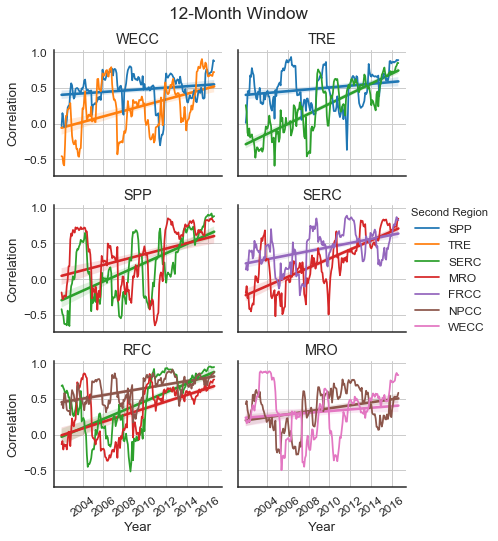

In [64]:
rolling_corr_plot(index, region_pairs=region_pairs, window=12,
                  detrend_series=True, seasonal=True,
                  sup_title='12-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 12m centered.pdf')
plt.savefig(path, bbox_inches='tight')

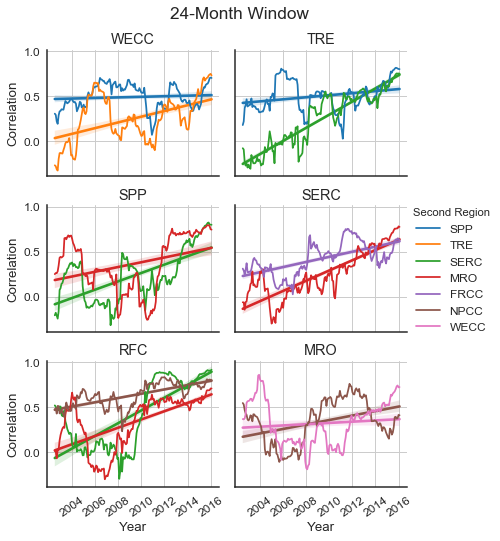

In [65]:
rolling_corr_plot(index, region_pairs=region_pairs, window=24,
                  detrend_series=True, seasonal=True,
                  sup_title='24-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 24m centered.pdf')
plt.savefig(path, bbox_inches='tight')

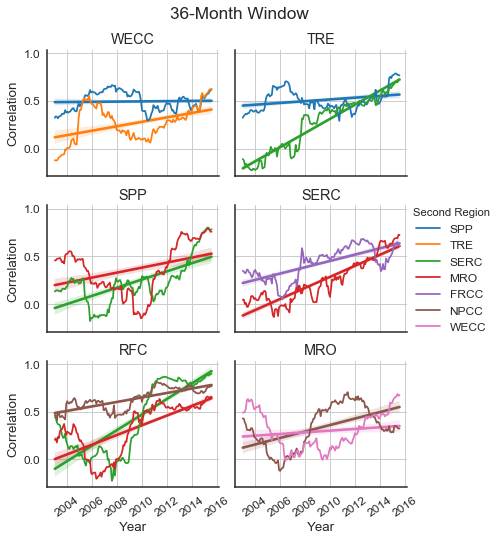

In [67]:
rolling_corr_plot(index, region_pairs=region_pairs, window=36,
                  detrend_series=True, seasonal=True, 
                  sup_title='36-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 36m centered.pdf')
plt.savefig(path, bbox_inches='tight')

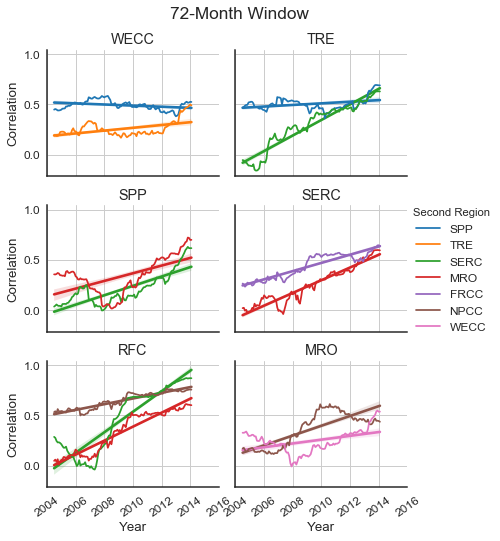

In [66]:
rolling_corr_plot(index, region_pairs=region_pairs, window=72,
                  detrend_series=True, seasonal=True,
                  sup_title='72-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 72m centered.pdf')
plt.savefig(path, bbox_inches='tight')

## Changes in CO₂ intensity for each NERC region

In [68]:
index.head()

index  change since 2005  final co2 (kg)  generation (mwh)  \
nerc datetime                                                                 
-    2001-01-01      0                NaN    5.476076e+09       7185661.388   
     2001-02-01      1                NaN    4.349473e+09       6526739.453   
     2001-03-01      2                NaN    4.223575e+09       6304139.884   
     2001-04-01      3                NaN    4.544873e+09       6624660.323   
     2001-05-01      4                NaN    4.972656e+09       7045482.729   

                 index (g/kwh)  index (lb/mwh)  month  quarter  year  
nerc datetime                                                         
-    2001-01-01     762.083771             NaN      1      NaN  2001  
     2001-02-01     666.408193             NaN      2      NaN  2001  
     2001-03-01     669.968545             NaN      3      NaN  2001  
     2001-04-01     686.053817             NaN      4      NaN  2001  
     2001-05-01     705.793523             NaN      5      NaN  2001

In [72]:
annual_index = (index.drop('index', axis=1)
                     .reset_index()
                     .groupby(['year', 'nerc'])
                     .sum())
annual_index['index (g/kwh)'] = (annual_index['final co2 (kg)']
                                 / annual_index['generation (mwh)'])
annual_index.sort_index(inplace=True)

In [73]:
annual_index.head()

change since 2005  final co2 (kg)  generation (mwh)  index (g/kwh)  \
year nerc                                                                       
2001 -                   NaN    6.282915e+10      8.687608e+07     723.204245   
     FRCC                NaN    1.133053e+11      1.769298e+08     640.396938   
     MRO                 NaN    1.401621e+11      1.605119e+08     873.218911   
     NPCC                NaN    9.502271e+10      2.414221e+08     393.595809   
     RFC                 NaN    5.698209e+11      8.331239e+08     683.956931   

           index (lb/mwh)  month  quarter  
year nerc                                  
2001 -                NaN     78      NaN  
     FRCC             NaN     78      NaN  
     MRO              NaN     78      NaN  
     NPCC             NaN     78      NaN  
     RFC              NaN     78      NaN

In [74]:
annual_index.loc[idx[:, 'USA'], :]

,,change since 2005,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,quarter
year,nerc,,,,,,,
2001,USA,0.597795,2.358945e+12,3.736644e+09,631.300499,16684.737740,78,30.0
2002,USA,0.322061,2.382179e+12,3.858452e+09,617.392375,16319.549907,78,30.0
2003,USA,0.376829,2.407509e+12,3.883185e+09,619.983049,16392.085946,78,30.0
2004,USA,0.029118,2.391809e+12,3.970555e+09,602.386528,15931.571617,78,30.0
2005,USA,-0.006476,2.436302e+12,4.055423e+09,600.751673,15884.430996,78,30.0
2006,USA,-0.276046,2.387001e+12,4.064702e+09,587.251136,15527.406603,78,30.0
2007,USA,-0.223557,2.451740e+12,4.156745e+09,589.822123,15596.924419,78,30.0
2008,USA,-0.379183,2.397134e+12,4.119388e+09,581.915115,15390.810992,78,30.0
2009,USA,-0.985714,2.180357e+12,3.950331e+09,551.942873,14587.510098,78,30.0


Annual CO₂ intensity in 2001 and 2016

In [78]:
annual_index.loc[idx[[2001, 2016], :], 'index (g/kwh)']

year  nerc
2001  -       723.204245
      FRCC    640.396938
      MRO     873.218911
      NPCC    393.595809
      RFC     683.956931
      SERC    652.136544
      SPP     829.332952
      TRE     595.902768
      USA     631.300499
      WECC    525.236421
2016  -       603.112752
      FRCC    434.127780
      MRO     522.781990
      NPCC    201.902086
      RFC     485.397446
      SERC    479.894696
      SPP     522.683878
      TRE     449.104935
      USA     455.845607
      WECC    349.826445
Name: index (g/kwh), dtype: float64

Change in CO₂ intensity (absolute and per year) from 2001-2016

In [75]:
(((annual_index.loc[2001, 'index (g/kwh)']
  - annual_index.loc[2016, 'index (g/kwh)'])).sort_values(),
((annual_index.loc[2001, 'index (g/kwh)']
  - annual_index.loc[2016, 'index (g/kwh)'])).sort_values() / 15)

(nerc
 -       120.091492
 TRE     146.797833
 SERC    172.241848
 WECC    175.409976
 USA     175.454892
 NPCC    191.693722
 RFC     198.559486
 FRCC    206.269158
 SPP     306.649074
 MRO     350.436922
 Name: index (g/kwh), dtype: float64, nerc
 -        8.006099
 TRE      9.786522
 SERC    11.482790
 WECC    11.693998
 USA     11.696993
 NPCC    12.779581
 RFC     13.237299
 FRCC    13.751277
 SPP     20.443272
 MRO     23.362461
 Name: index (g/kwh), dtype: float64)

Percent change in CO₂ intensity from 2001-2016

In [80]:
((annual_index.loc[2001, 'index (g/kwh)']
  - annual_index.loc[2016, 'index (g/kwh)'])
 / annual_index.loc[2001, 'index (g/kwh)']).sort_values()

nerc
-       0.166055
TRE     0.246345
SERC    0.264119
USA     0.277926
RFC     0.290310
FRCC    0.322096
WECC    0.333964
SPP     0.369754
MRO     0.401316
NPCC    0.487032
Name: index (g/kwh), dtype: float64